# Stellargraph example: GraphSAGE on the CORA citation network

This notebook demonstrated node attribute inference using the GraphSAGE algorithm. 

**References**

[1] Inductive Representation Learning on Large Graphs, W. L. Hamilton, R. Ying, and J. Leskovec, NIPS 2017


Copyright 2010-2019 Commonwealth Scientific and Industrial Research Organisation (CSIRO).

All Rights Reserved.

Import NetworkX and stellar:

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

Using TensorFlow backend.


### Loading the CORA network

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`../data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [3]:
data_dir = os.path.expanduser("../data/cora")

Load the edgelist from the `.cites` file

In [4]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["source", "target"])

Next we create a networkx object from this edgelist:

In [5]:
g_nx = nx.from_pandas_edgelist(edgelist)

The node features and subject are in a seperate file. We load this using pandas:

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [8]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=0.1, test_size=None, stratify=node_data['subject'], random_state=42)

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Neural_Networks': 81,
         'Genetic_Algorithms': 42,
         'Theory': 35,
         'Probabilistic_Methods': 42,
         'Case_Based': 30,
         'Rule_Learning': 18,
         'Reinforcement_Learning': 22})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

In [12]:
node_features.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [13]:
G = sg.StellarGraph(g_nx, node_features=node_features)

In [14]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  default: [2708]
    Edge types: default-default->default

 Edge types:
    default-default->default: [5278]



To feed data from the graph to the Keras model we need a mapper. The mappers are specialized to the model and the learning task so we choose the `GraphSAGENodeMapper` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [15]:
batch_size = 50; num_samples = [10, 10]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [16]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

For training we map only the training nodes returned from our splitter and the target values.

In [17]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [18]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    dropout=0.5,
)

Now we create a Keras/Tensorflow graph of the GraphSAGE model, where `x_out` is the output node embedding and `x_inp` is the sampled neighbourhood of the node provided by the generator:

In [25]:
x_inp, x_out = graphsage_model.node_model(flatten_output=True)

Next using the node embedding `x_out` we predict the 7 categories using a Keras dense layer with softmax activation:

In [26]:
prediction = layers.Dense(units=7, activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [29]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [30]:
test_gen = generator.flow(test_data.index, test_targets)

In [31]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    verbose=2,
    shuffle=True,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
 - 4s - loss: 1.8958 - acc: 0.2444 - val_loss: 1.6979 - val_acc: 0.4073
Epoch 2/20
 - 4s - loss: 1.6168 - acc: 0.4889 - val_loss: 1.5218 - val_acc: 0.4733
Epoch 3/20
 - 4s - loss: 1.4349 - acc: 0.6185 - val_loss: 1.4102 - val_acc: 0.6222
Epoch 4/20
 - 4s - loss: 1.2630 - acc: 0.7815 - val_loss: 1.2637 - val_acc: 0.7223
Epoch 5/20
 - 4s - loss: 1.1333 - acc: 0.8481 - val_loss: 1.2065 - val_acc: 0.7691
Epoch 6/20
 - 4s - loss: 1.0111 - acc: 0.9037 - val_loss: 1.1114 - val_acc: 0.7633
Epoch 7/20
 - 4s - loss: 0.9120 - acc: 0.9148 - val_loss: 1.0892 - val_acc: 0.7822
Epoch 8/20
 - 4s - loss: 0.8117 - acc: 0.9481 - val_loss: 0.9688 - val_acc: 0.7941
Epoch 9/20
 - 4s - loss: 0.7366 - acc: 0.9519 - val_loss: 0.9077 - val_acc: 0.8109
Epoch 10/20
 - 4s - loss: 0.6711 - acc: 0.9481 - val_loss: 0.8968 - val_acc: 0.8068
Epoch 11/20
 - 4s - loss: 0.6055 - acc: 0.9667 - val_loss: 0.8840 - val_ac

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

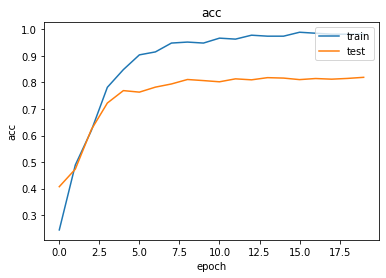

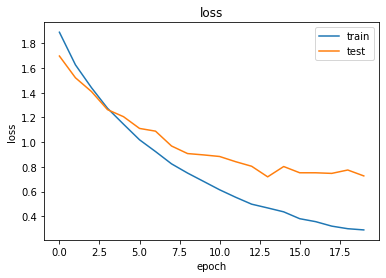

In [33]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [34]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.7564
	acc: 0.8179


### Making predictions with the model

Now let's get the predictions themselves for all nodes using another mapper:

In [35]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [36]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few:

In [37]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(10)

,Predicted,True
31336,subject=Neural_Networks,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Neural_Networks,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Reinforcement_Learning,Theory
1102850,subject=Neural_Networks,Neural_Networks
31349,subject=Neural_Networks,Neural_Networks
1106418,subject=Theory,Theory


Add the predictions to the graph, and save as graphml, e.g. for visualisation in [Gephi](https://gephi.org)

In [38]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    g_nx.node[nid]["subject"] = true
    g_nx.node[nid]["PREDICTED_subject"] = pred.split("=")[-1]

Also add isTrain and isCorrect node attributes:

In [39]:
for nid in train_data.index:
    g_nx.node[nid]["isTrain"] = True
    
for nid in test_data.index:
    g_nx.node[nid]["isTrain"] = False

In [40]:
for nid in g_nx.nodes():
    g_nx.node[nid]["isCorrect"] = g_nx.node[nid]["subject"] == g_nx.node[nid]["PREDICTED_subject"]

Save in GraphML format

In [41]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(g_nx, os.path.join(data_dir,pred_fname))

## Node embeddings
Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [42]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [43]:
emb = embedding_model.predict_generator(all_mapper)
emb.shape

(2708, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [45]:
X = emb
y = np.argmax(target_encoding.transform(node_data[["subject"]].to_dict('records')), axis=1)

In [46]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

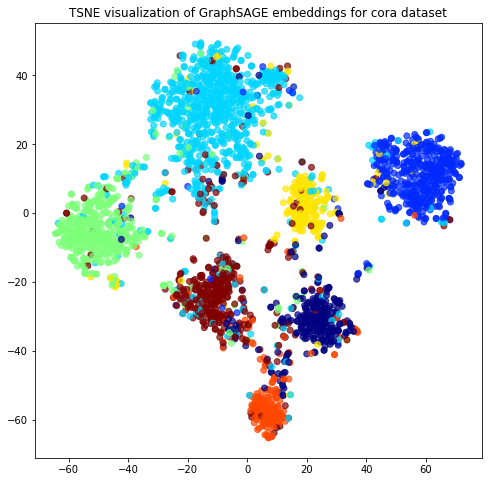

In [47]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
#ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()